# Forecasting UK Electricity prices with LSTM and CNN+LSTM for Multivariate time series 

In [0]:
import pandas as pd
from datetime import datetime
import numpy as np

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


TensorFlow 2.x selected.


In [0]:
import tensorflow as tf

In [3]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


Using TensorFlow backend.


In [4]:
df=pd.read_csv("electricity-prices.csv",index_col=[0], parse_dates=[0])
df.head(3)

,Price,Volume,Settlement Period,hour,quarter,year,dayofyear,dayofmonth,weekofyear,SAP,EU_ETS,Gas,INDO
datetime,,,,,,,,,,,,,
2017-01-01 00:00:00,44.90,505.00,1,0.0,1.0,2017.0,1.0,1.0,52.0,16.95,1.033832,21.294832,27239
2017-01-01 00:30:00,47.13,559.15,2,0.0,1.0,2017.0,1.0,1.0,52.0,16.95,1.033832,21.294832,27814
2017-01-01 01:00:00,45.62,649.35,3,1.0,1.0,2017.0,1.0,1.0,52.0,16.95,1.033832,21.294832,27453


In [0]:
def limit(data, frm, to):
    return data[(data.index>=frm)&(data.index<to)]

In [6]:
new_df = limit(df,'2019-01-01', '2019-06-30')
new_df.shape

(8530, 13)

In [7]:
new_df = new_df[['Price', 'INDO', 'Gas']]
new_df.head(3)

,Price,INDO,Gas
datetime,,,
2019-01-01 00:00:00,48.81,23712,24.560535
2019-01-01 00:30:00,50.24,24315,24.560535
2019-01-01 01:00:00,41.90,24037,24.560535


In [0]:
new_df.to_csv('small_elec.csv')

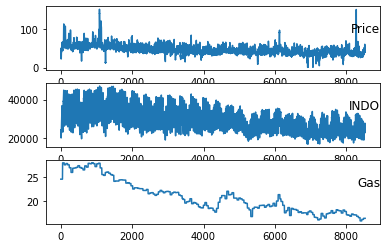

In [9]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = read_csv('small_elec.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [0]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler 

In [11]:
dataset.shape

(8530, 3)

In [12]:
dataset.head(3)

,Price,INDO,Gas
datetime,,,
2019-01-01 00:00:00,48.81,23712,24.560535
2019-01-01 00:30:00,50.24,24315,24.560535
2019-01-01 01:00:00,41.90,24037,24.560535


In [0]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [14]:
# load dataset
dataset = pd.read_csv('small_elec.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,2] = encoder.fit_transform(values[:,2])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1,2)
# drop columns we don't want to predict
reframed.drop(reframed.columns[4:], axis=1, inplace=True)
print(reframed.head())
print(reframed.shape)

   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
1   0.318158   0.229593   0.832402  0.327607
2   0.327607   0.249464   0.832402  0.272499
3   0.272499   0.240303   0.832402  0.255451
4   0.255451   0.208502   0.832402  0.220893
5   0.220893   0.179898   0.832402  0.192877
(8528, 4)


In [17]:
scaled.shape

(8530, 3)

Define and Fit model : LSTM
The example below splits the dataset into train and test sets, then splits the train and test sets into input and output variables. Finally, the inputs (X) are reshaped into the 3D format expected by LSTMs, namely [samples, timesteps, features].

In [15]:
# split into train and test sets
values = reframed.values
n_train_hours = 7760 #8064 Split_time
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1 ], train[:,-1 ]
test_X, test_y = test[:, :-1], test[:,-1 ]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(7760, 1, 3) (7760,) (768, 1, 3) (768,)


In [19]:
input_shape=train_X.shape[1], train_X.shape[2]
print(input_shape)

(1, 3)


In [20]:
train_X

array([[[0.31815782, 0.22959298, 0.8324022 ]],

       [[0.32760674, 0.24946445, 0.8324022 ]],

       [[0.27249902, 0.24030316, 0.8324022 ]],

       ...,

       [[0.29119864, 0.47391665, 0.26256981]],

       [[0.28366593, 0.42774755, 0.26256981]],

       [[0.2649663 , 0.3691547 , 0.26256981]]], dtype=float32)

## LSTM algorithm: for multivariate time series 

Train on 7760 samples, validate on 768 samples
Epoch 1/50
7760/7760 - 7s - loss: 0.1013 - val_loss: 0.0400
Epoch 2/50
7760/7760 - 0s - loss: 0.0355 - val_loss: 0.0376
Epoch 3/50
7760/7760 - 0s - loss: 0.0323 - val_loss: 0.0356
Epoch 4/50
7760/7760 - 0s - loss: 0.0302 - val_loss: 0.0336
Epoch 5/50
7760/7760 - 0s - loss: 0.0283 - val_loss: 0.0311
Epoch 6/50
7760/7760 - 0s - loss: 0.0265 - val_loss: 0.0285
Epoch 7/50
7760/7760 - 0s - loss: 0.0248 - val_loss: 0.0257
Epoch 8/50
7760/7760 - 0s - loss: 0.0230 - val_loss: 0.0231
Epoch 9/50
7760/7760 - 0s - loss: 0.0213 - val_loss: 0.0208
Epoch 10/50
7760/7760 - 0s - loss: 0.0198 - val_loss: 0.0189
Epoch 11/50
7760/7760 - 0s - loss: 0.0186 - val_loss: 0.0178
Epoch 12/50
7760/7760 - 0s - loss: 0.0178 - val_loss: 0.0175
Epoch 13/50
7760/7760 - 0s - loss: 0.0172 - val_loss: 0.0175
Epoch 14/50
7760/7760 - 0s - loss: 0.0170 - val_loss: 0.0174
Epoch 15/50
7760/7760 - 0s - loss: 0.0170 - val_loss: 0.0173
Epoch 16/50
7760/7760 - 0s - loss: 0.0170 - val

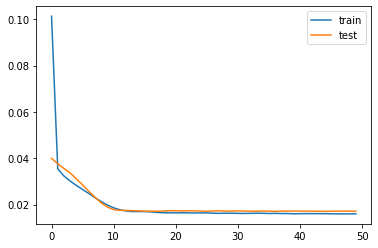

In [23]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tf.keras.layers.Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


In [0]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]


In [25]:
#Evaluation: forcasted values vs. real values
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse,rmse
error1 = mse(inv_y, inv_yhat)
error2 = rmse(inv_y, inv_yhat)
error3 = mean_absolute_error(inv_y, inv_yhat)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(inv_y), np.array(inv_yhat)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

error4 = mean_absolute_percentage_error(inv_y, inv_yhat)

print(f'MAE Error: {error3:11.10}') 
print(f'MSE Error : {error1:11.10}')
print(f'RMSE Error: {error2:11.10}')
print(f'MAPE Error: {error4:11.10}')


MAE Error: 2.592669249
MSE Error : 19.47518158
RMSE Error: 4.413069248
MAPE Error:  6.53289482


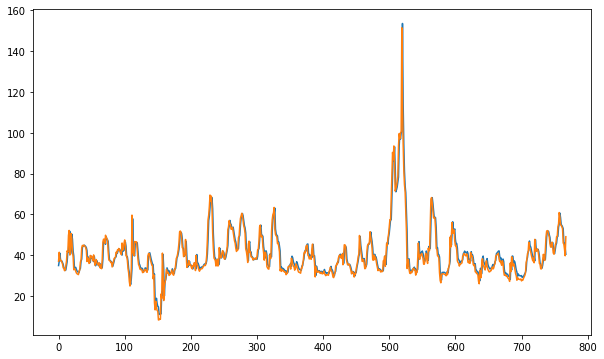

In [27]:
pyplot.figure(figsize=(10, 6))
pyplot.plot(inv_yhat)
pyplot.plot(inv_y)
pyplot.show()


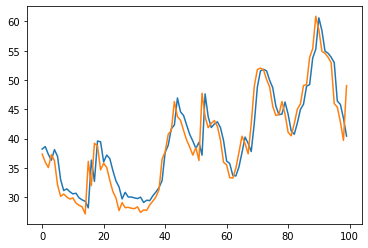

In [28]:
pyplot.plot(inv_yhat[-100:])
pyplot.plot(inv_y[-100:])
pyplot.show()

## LSTM with convolution layer on top for multivariate time series

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
#window_size=60

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None,3]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


In [19]:
optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
#history = model.fit(train_set,epochs=70)
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 7760 samples, validate on 768 samples
Epoch 1/100
7760/7760 - 4s - loss: 0.0881 - mae: 0.2344 - val_loss: 0.0043 - val_mae: 0.0688
Epoch 2/100
7760/7760 - 1s - loss: 0.0032 - mae: 0.0569 - val_loss: 0.0042 - val_mae: 0.0695
Epoch 3/100
7760/7760 - 1s - loss: 0.0023 - mae: 0.0488 - val_loss: 0.0041 - val_mae: 0.0684
Epoch 4/100
7760/7760 - 1s - loss: 0.0020 - mae: 0.0457 - val_loss: 0.0038 - val_mae: 0.0655
Epoch 5/100
7760/7760 - 1s - loss: 0.0018 - mae: 0.0440 - val_loss: 0.0036 - val_mae: 0.0644
Epoch 6/100
7760/7760 - 1s - loss: 0.0017 - mae: 0.0427 - val_loss: 0.0033 - val_mae: 0.0616
Epoch 7/100
7760/7760 - 1s - loss: 0.0017 - mae: 0.0420 - val_loss: 0.0030 - val_mae: 0.0582
Epoch 8/100
7760/7760 - 1s - loss: 0.0017 - mae: 0.0416 - val_loss: 0.0029 - val_mae: 0.0562
Epoch 9/100
7760/7760 - 1s - loss: 0.0016 - mae: 0.0415 - val_loss: 0.0028 - val_mae: 0.0543
Epoch 10/100
7760/7760 - 1s - loss: 0.0016 - mae: 0.0413 - val_loss: 0.0027 - val_mae: 0.0528
Epoch 11/100
7760/7760

In [0]:
from matplotlib import pyplot as plt
#optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

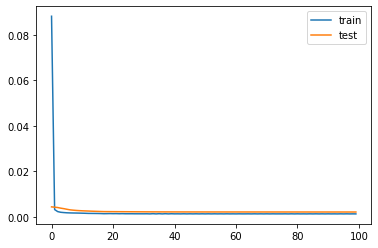

In [20]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [0]:
# make a prediction
yhat = model.predict(test_X)
yhat = yhat.reshape(yhat.shape[0],yhat.shape[2])
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]


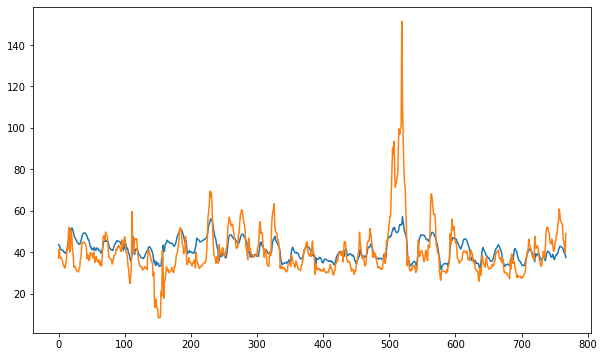

In [22]:
pyplot.figure(figsize=(10, 6))
pyplot.plot(inv_yhat)
pyplot.plot(inv_y)
pyplot.show()

In [94]:
#Evaluation: forcasted values vs. real values
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse,rmse
error1 = mse(inv_y, inv_yhat)
error2 = rmse(inv_y, inv_yhat)
error3 = mean_absolute_error(inv_y, inv_yhat)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(inv_y), np.array(inv_yhat)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

error4 = mean_absolute_percentage_error(inv_y, inv_yhat)

print(f'MAE Error: {error3:11.10}') 
print(f'MSE Error : {error1:11.10}')
print(f'RMSE Error: {error2:11.10}')
print(f'MAPE Error: {error4:11.10}')


MAE Error: 6.416340351
MSE Error : 95.23300934
RMSE Error: 9.758740425
MAPE Error: 17.38224179
